<a href="https://colab.research.google.com/github/JesseKiguta/sound-clustering-assignment/blob/main/sound_clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [69]:
import numpy as np
import librosa
import os
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from google.colab import drive

In [33]:
# Load the Data
drive.mount('/content/drive')
unlabelled_data_path = '/content/drive/MyDrive/unlabelled_sounds/unlabelled_sounds/'

# Extract Features
features = []
file_names = []

for file in os.listdir(unlabelled_data_path):
  if file.endswith('.wav'):
    # Extract audio files
    file_path = os.path.join(unlabelled_data_path, file)
    y, sr = librosa.load(file_path, sr=None)

    # Extract MFCCs from audio files
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=512)
    mfcc_mean = np.mean(mfcc, axis=1)
    features.append(mfcc_mean)
    file_names.append(file)

X = np.array(features)
print("Feature Matrix Shape:", X.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Feature Matrix Shape: (3000, 13)


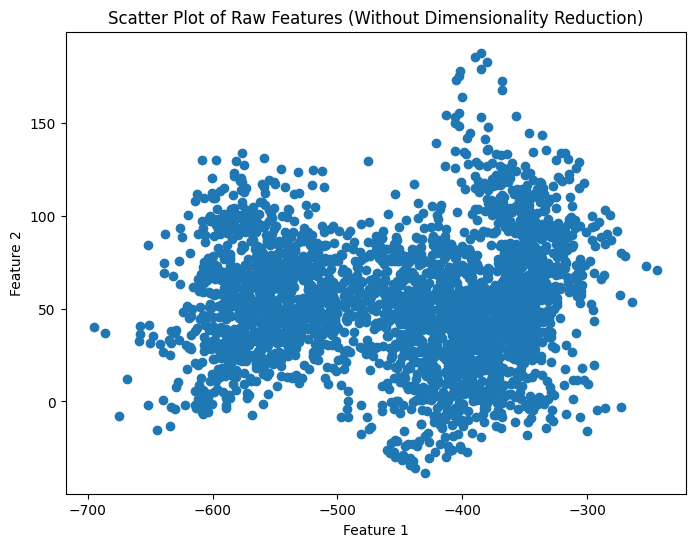

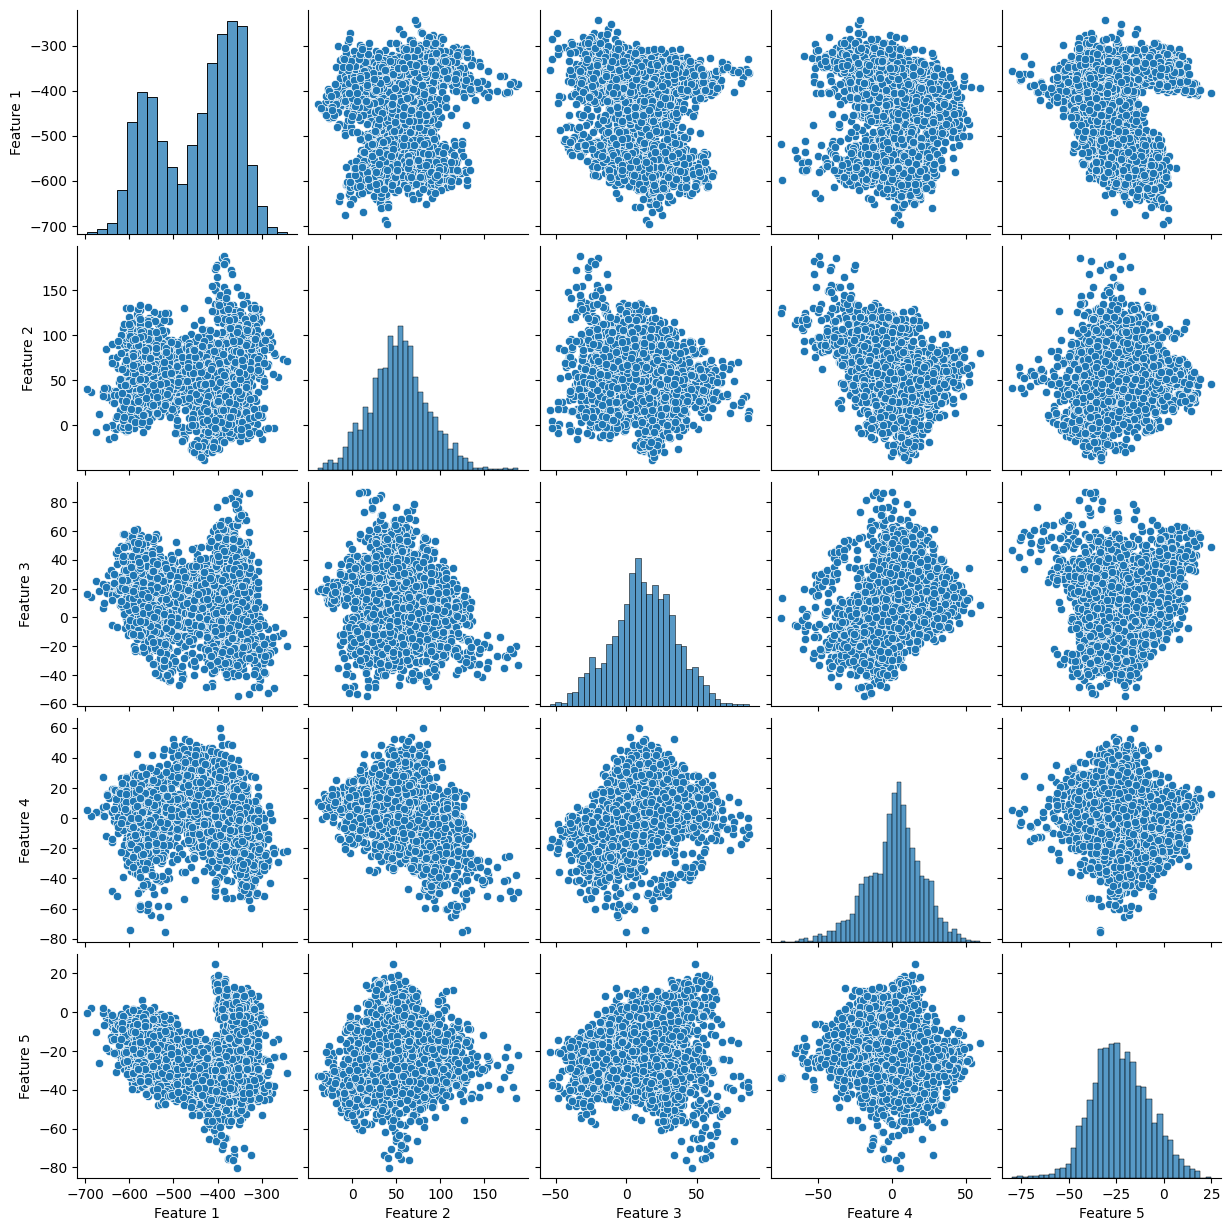

In [34]:
# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
df = pd.DataFrame(X[:, :5], columns=[f"Feature {i+1}" for i in range(5)])
sns.pairplot(df)
plt.show()

### Why is dimensionality reduction important?

Dimensionality reduction is important for several reasons:
1. It makes clustering algorithms have an easier time when determining the number of clusters the data has. The scatter plot of raw features above is a good demonstration of it because without any preprocessing, there are no discernable clusters.
2. It is a requirement for visualization. The data needs to be in either 2 or 3 dimensions to be visualized by libraries such as matplotlib.
3. Raw audio files contain noise (we can see this in the similarity between the graphs of the first five features) and we want to extract the meaningful information only for this task, so dimensionality reduction helps us remove this noise.
4. Low dimension data takes up less computational resources than the unprocessed high dimension data we're starting off with.

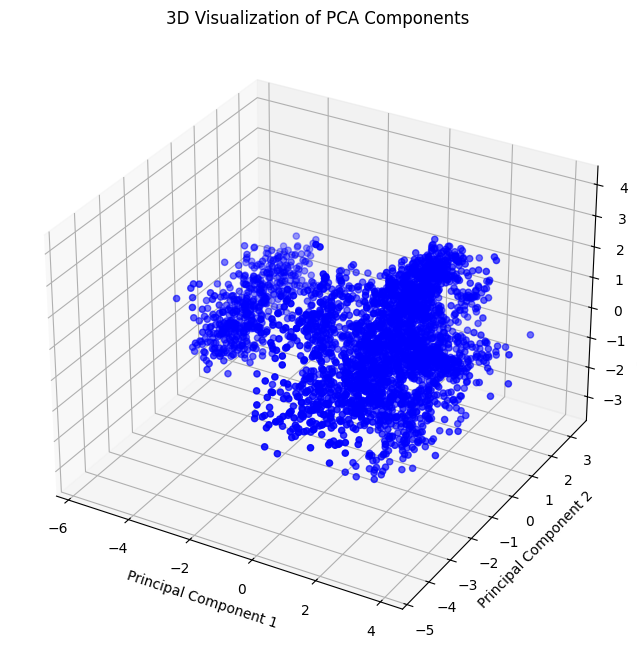

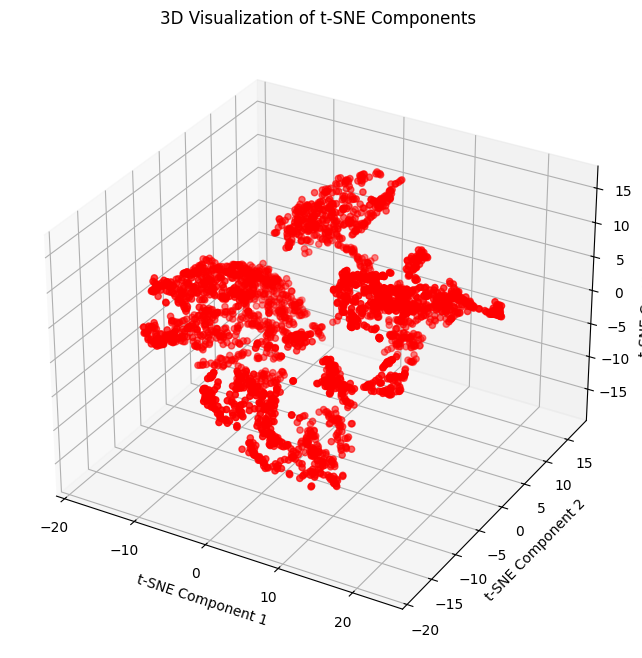

In [70]:
# Apply PCA (3 components)
pca = PCA(n_components=3)
X_scaled = StandardScaler().fit_transform(X)
features_pca = pca.fit_transform(X_scaled)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, random_state=42)
features_tsne = tsne.fit_transform(X)

# 3D Visualization (PCA)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c='b', marker='o')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Visualization of PCA Components')
plt.show()

# 3D Visualization (TSNE)
fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], c='r', marker='o')

ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')
ax2.set_zlabel('t-SNE Component 3')
ax2.set_title('3D Visualization of t-SNE Components')
plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?

TSNE separated the clusters better than PCA according to the plots above. PCA has one big cluster and one small cluster while TSNE has several smaller clusters with some overlap between clusters.

The reason behind this? PCA is good at capturing the global structure of the data while TSNE is good at local structure of the data. Naturally, TSNE would be more focused on keeping similar points closer together than PCA. This property of TSNE works well with our sound data because we want similar sounds in well-separated groups.

In [36]:
!pip install kneed

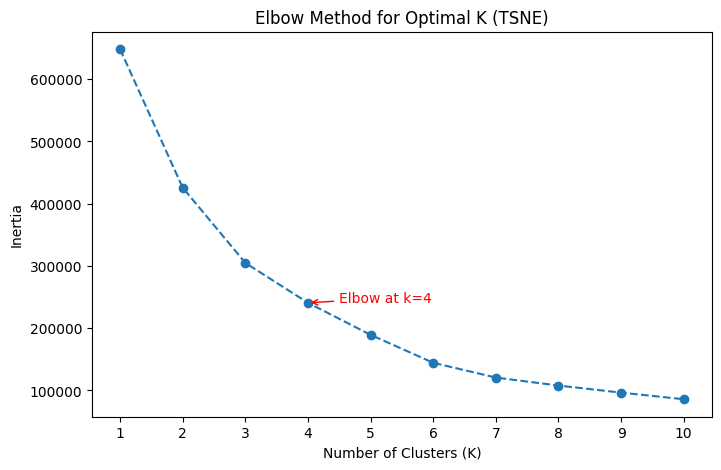

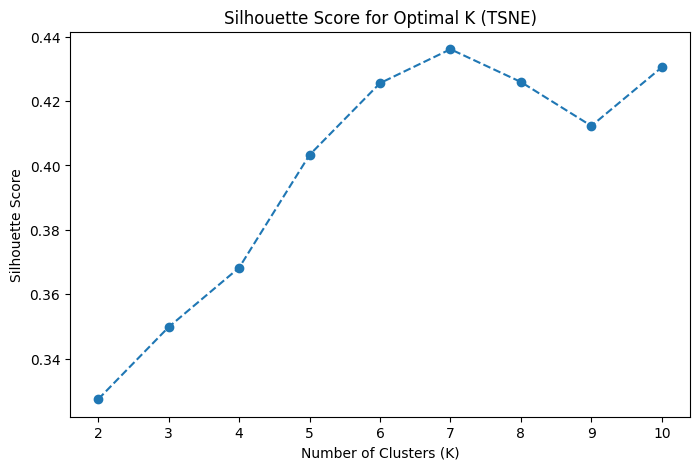

In [37]:
from kneed import KneeLocator

# Optimize number of clusters using Elbow Method
kmeans = KMeans(random_state=42, n_init=10)
inertia = []
silhouette = [] # Initialize silhouette list here

for k in range(1, 11):
    kmeans.set_params(n_clusters=k)
    kmeans.fit(features_tsne)
    inertia.append(kmeans.inertia_)
    # Calculate silhouette score for each k > 1
    if k > 1:
        silhouette.append(silhouette_score(features_tsne, kmeans.labels_))
    else:
        silhouette.append(None) # Append None for k=1 as silhouette score is not defined

# Find Elbow using Kneed
kneedle = KneeLocator(range(1, 11), inertia, curve="convex", direction="decreasing")
elbow_k = kneedle.knee
elbow_inertia = inertia[elbow_k - 1] if elbow_k is not None else None

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xticks(range(1, 11))
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K (TSNE)')

# Annotate elbow point
if elbow_k is not None:
    plt.annotate(
        f'Elbow at k={elbow_k}',
        xy=(elbow_k, elbow_inertia),
        xytext=(elbow_k + 0.5, elbow_inertia + 1000),
        arrowprops=dict(arrowstyle='->', color='red'),
        fontsize=10,
        color='red'
    )
else:
    print("Elbow point not found automatically.")

plt.show()

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette[1:], marker='o', linestyle='--') # Plot from k=2
plt.xticks(range(2, 11))
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K (TSNE)')
plt.show()

Elbow detected at eps ≈ 0.631


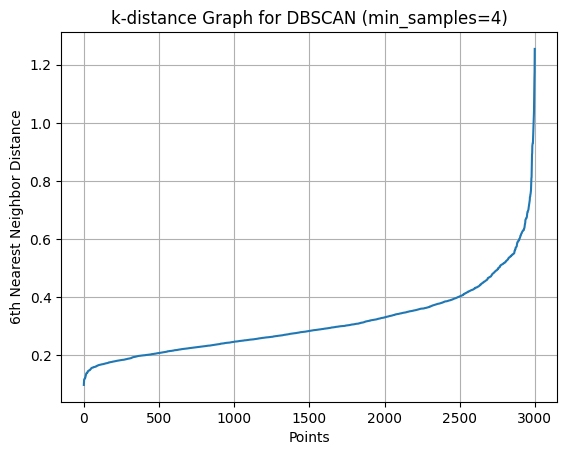

In [77]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)  # min_samples + 1
neighbors_fit = neighbors.fit(features_pca)
distances, indices = neighbors_fit.kneighbors(features_pca)
distances = np.sort(distances[:, 4])  # 5 because it's the 6th neighbor
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("6th Nearest Neighbor Distance")
plt.title("k-distance Graph for DBSCAN (min_samples=4)")
plt.grid(True)

kneedle = KneeLocator(
    range(len(distances)),
    distances,
    S=1.0,
    curve='convex',
    direction='increasing'
)

elbow_index = kneedle.knee
elbow_eps = distances[elbow_index]

print(f"Elbow detected at eps ≈ {elbow_eps:.3f}")

plt.show()

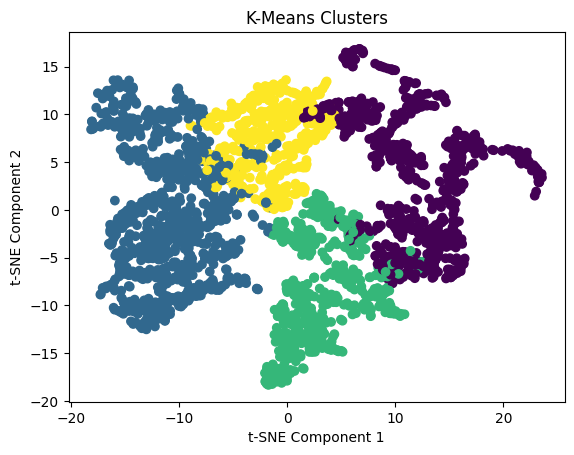

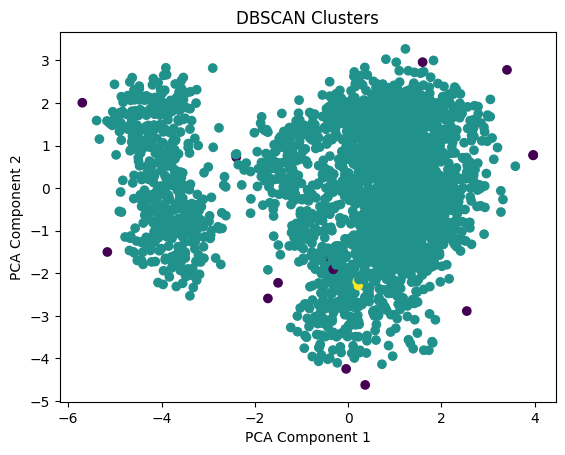

In [78]:
# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_tsne)

# Apply DBSCAN
dbscan = DBSCAN(eps=elbow_eps, min_samples=4)
dbscan_labels = dbscan.fit_predict(features_pca)

# Scatter Plot for K-Means Clusters
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("K-Means Clusters")
plt.show()

# Scatter Plot for DBSCAN Clusters
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap='viridis')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clusters")
plt.show()

In [79]:
# Evaluate clustering
kmeans_silhouette = silhouette_score(features_tsne, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_tsne, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_pca, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_pca, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")

K-Means - Silhouette Score: 0.3605, Davies-Bouldin Index: 1.0257
DBSCAN - Silhouette Score: 0.1768, Davies-Bouldin Index: 4.2105


### Discuss the results (max 5 lines)
KMeans outperformed DBSCAN on both metrics by a wide margin. KMeans' silhouette score implies an average cluster separation and cohesion showing some looseness in the clusters while DBSCAN's shows poor clustering separation and cohesion. Looking at the DB Index for both, KMeans has a low clustering overlap which points to good clustering quality and DBSCAN has very high clustering overlap indicating issues with handling non-linear patterns in the feature space and possible noise contamination.

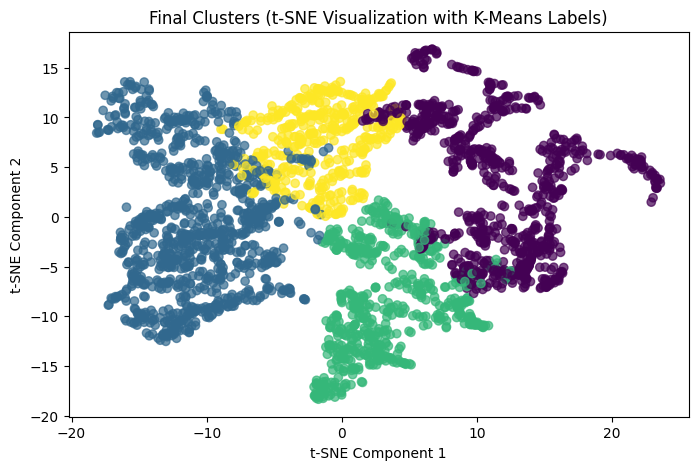

In [40]:
# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()

### Final Analysis

### Explain why dimensionality reduction helped (or didn't) in clustering.

Dimensionality reduction helped with enabling the clustering methods (KMeans and DBSCAN) to form clusters. TSNE features were used for KMeans which led to fairly distinct clusters. On the other hand, PCA features were used for DBSCAN which formed clusters that had very high overlap which was an improvement from using TSNE features that were unable to form clusters at all. The problems that the DBSCAN clustering method had originated from the issues that PCA had with separating clusters during dimensionality reduction.

### Justify why certain clustering methods worked better.

KMeans outperformed DBSCAN on every performance metric. It made good quality clusters in terms of their internal structure and overlap. This suggests that the structure of the data aligns with the assumptions made by the KMeans algorithm, that the clusters formed are roughly spherical and similar in size.

### Relate findings to real-world clustering challenges.

1. The choice of clustering algorithms matters, there is no universal clustering method.
2. Preprocessing and feature engineering are critical. The issues with feature scaling in PCA carried over to the DBSCAN algorithm.
3. Dimensionality reduction has trade-offs. Finding the sweet spot between too much noise and too little structures requires domain knowledge.
4. Real-world clustering needs smart evaluation without labels. For this project, we were evaluating clustering performance with arbitrary metrics such as Silhouette score and DB Index that require a good understanding of how they work.